In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Major League Baseball Most Valuable Player Report
#### Samantha Delfino 
#### 21 August 2019

## Introduction

The Major League Baseball (MLB) Most Valuable Player (MVP) Award is one of the most prestigious awards available in the MLB. This award is given annually in the National League and American League to the most outstanding player in their respective leagues. There is no definition for what deems a player outstanding so there could be nominations for the MVP for very different reasons by each voter.  It is up to the voter to determine what they believe is the meaning of an outstanding player. Baseball Writers Association of America nominates two sports writers for every city that hosts an MLB team. The sports writers vote in the league that the team in their city is in.  For example, the two sports writers from San Francisco will vote for the National League MVP.  The way the sports writers vote is by creating a list of the top ten players in the league they are voting in. Higher rankings on the list are awarded more points than lower rankings. First choice is awarded 14 points, second is awarded 9, third: 8, fourth: 7, fifth: 6, sixth: 5, seventh: 4, eighth: 3, ninth: 2, and tenth: 1. The player with the most points is awarded MVP for their league. The vote occurs after the end of the regular season but must be turned in before the beginning of the post season. The names of the winners of the award are released after the World Series.

The purpose of this report is to predict the MLB MVP before the sports writers begin their vote. The project initially started with a traditional statistical approach, trying to predict the MVP based on player statistics, comparing players only in their respective leagues. Such analytics and predictions proved inconclusive. The second approach was to predict the MVP based on how the sports writers report on each player, i.e. the more positively sports writers refer to a specific player, the more likely a player is to be the next MLB MVP.


## Statistical Analysis 

The statistical analysis portion of this project was the first attempt at predicting the MLB MVP. Whether the player is an MVP or not is a binary question, so a logistic regression model was the most intuitive way to attempt to predict the MLB MVP based purely on player statistics. The logistic regression model takes in one or more variables to then determine whether each player is either the MVP or not. There were many attempts at using logistic regression to create such a prediction. Methods attempted included: 
- trying different variables 
- collecting data in different time frames 
- aggregating player data seasonally 
- aggregating player data weekly 
- creating new variables

Unfortunately, most models had difficulty predicting the MVP purely based on player statistics. Below are the two main attempts that show key variables and the difference between measuring based on player data aggregated seasonally or player data aggregated weekly.

### Attempt 1

#### Data Set 

The data sets used for this analysis were from Fangraphs which contained the entirety of the 2017 season and the first half of the 2018 season and a list of MVP winners from 2003 until 2017 from Luhmann's Data. The data from Fangraphs contains the top 144 players in the MLB's statistics which are aggregated for the entire season or half season. The variables provided in the data were only available for the top 144 players. The decision to use only the top 144 players assumes that these top players are the ones in contention for the award. Any player lower than the top 144 are not included because they do not have a chance at the MVP award.

The data was split into the 2017 season and the first half of 2018 season, with a column indication 0 for those that had not previously won the MVP award and 1 for those that have. The idea to use 2003 until 2017 MVP winners is because if only 2017's winners were used in 2017 data, there would not be enough MVP indicators to be able to properly train the data.  Even with oversampling, the training data won’t work in the model using only 2017’s winners. In the 2018 data the MVPs were indicated for 2003 until 2017 to have MVP indicators to test against. The predictor model would not be able to work if there are no players identified as MVP's in previous years because then there would only be 0's in testing data, causing the logistic regression model to fail.

The data is split into the National League and American League. Each set of data is tested separately, since there is a winner for the National League and the American League. The 2017 season data for each league is the training data for each logistic regression model, while the first half of the 2018 season for each league is the testing data.

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R 
library(stringr)
library(dplyr)
library(tidyr)

MVP = read.csv("~/Desktop/MLB_MVP/baseballdatabank-2019.2 2/luhmanns_data/AwardsPlayers.csv", sep = ",", stringsAsFactors = F) %>% 
  subset(awardID == "Most Valuable Player") %>% 
  subset(yearID %in% c( "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017")) %>% 
  mutate(Name = c("Alex Rodriguez", "Barry Bonds", "Vladimir Guerrero", "Barry Bonds", "Alex Rodriguez", "Albert Pujols", "Justin Morneau", "Ryan Howard", "Alex Rodriguez", "Jimmy Rollins", "Dustin Pedroia", "Albert Pujols", "Joe Mauer", "Albert Pujols", "Josh Hamilton", "Joey Votto", "Justin Verlander", "Ryan Braun", "Miguel Cabrera", "Buster Posey", "Miguel Cabrera", "Andrew McCutchen", "Mike Trout", "Clayton Kershaw", "Josh Donaldson", "Bryce Harper", "Mike Trout", "Kris Bryant", "Jose Altuve", "Giancarlo Stanton")) %>% 
  select("Name", "awardID")

Season_2018 = read.csv("~/Desktop/MLB_MVP/WAR/FirstHalf2018WAR.csv", header = T, sep = ",", stringsAsFactors = F)%>% 
  left_join(MVP, by = "Name") %>% 
  mutate(awardID = case_when(awardID %in% NA ~ 0, 
                             awardID %in% "Most Valuable Player" ~ 1), Year = "2018",
         K. = gsub(pattern = "%", replacement = "", K.), BB. = gsub(pattern = "%", replacement = "", BB.), K. = as.numeric(K.), BB. = as.numeric(BB.), 
         League = case_when(Team %in% c("Rangers", "Twins", "Red Sox", "Yankees", "Orioles", "Mariners", "Tigers", "Royals", "Indians", "Blue Jays", "Angels", "Athletics", "Astros", "White Sox", "Rays") ~ "AL",
                            Team %in% c("Cubs", "Dodgers", "Braves", "Mets", "Brewers", "Cardinals", "Phillies", "Giants", "Nationals", "Reds", "Pirates", "Padres", "Rockies", "Diamondbacks", "Marlins")~ "NL")) %>% 
  
  mutate_if(is.integer, as.numeric) 


Season_2017 = read.csv("~/Desktop/MLB_MVP/WAR/2017SeasonWAR.csv", header = T, sep = ",", stringsAsFactors = F)%>% 
  left_join(MVP, by = "Name") %>% 
  mutate(awardID = case_when(awardID %in% NA ~ 0, 
                             awardID %in% "Most Valuable Player" ~ 1), Year = "2017",
         K. = gsub(pattern = "%", replacement = "", K.), BB. = gsub(pattern = "%", replacement = "", BB.), K. = as.numeric(K.), BB. = as.numeric(BB.), 
         League = case_when(Team %in% c("Rangers", "Twins", "Red Sox", "Yankees", "Orioles", "Mariners", "Tigers", "Royals", "Indians", "Blue Jays", "Angels", "Athletics", "Astros", "White Sox", "Rays") ~ "AL",
                            Team %in% c("Cubs", "Dodgers", "Braves", "Mets", "Brewers", "Cardinals", "Phillies", "Giants", "Nationals", "Reds", "Pirates", "Padres", "Rockies", "Diamondbacks", "Marlins")~ "NL")) %>% 
  mutate_if(is.integer, as.numeric) 

Season_2017_AL = Season_2017 %>% 
  filter(League == "AL")

Season_2017_NL = Season_2017 %>% 
  filter(League == "NL")


Season_2018_AL = Season_2018 %>% 
  filter(League == "AL")

Season_2018_NL = Season_2018 %>% 
  filter(League == "NL")


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




##### Figure 1

In [4]:
%%R -o Season_2018

Season_2018 = Season_2018

In [5]:
display(Season_2018[0:10])

,Name,Team,G,PA,HR,R,RBI,SB,BB.,K.,...,wOBA,wRC.,BsR,Off,Def,WAR,playerid,awardID,Year,League
1,Didi Gregorius,Yankees,28.0,121.0,10.0,24.0,30.0,2.0,14.9,13.2,...,0.463,197.0,0.6,14.7,2.1,2.1,6012.0,0.0,2018,AL
2,Mookie Betts,Red Sox,24.0,107.0,8.0,29.0,18.0,3.0,12.1,11.2,...,0.481,206.0,0.8,14.4,2.0,2.1,13611.0,0.0,2018,AL
3,Mike Trout,Angels,28.0,125.0,10.0,21.0,18.0,5.0,16.0,20.0,...,0.432,181.0,1.2,13.3,0.9,1.9,10155.0,1.0,2018,AL
4,Mike Trout,Angels,28.0,125.0,10.0,21.0,18.0,5.0,16.0,20.0,...,0.432,181.0,1.2,13.3,0.9,1.9,10155.0,1.0,2018,AL
5,Manny Machado,Orioles,28.0,125.0,9.0,14.0,22.0,2.0,13.6,12.8,...,0.464,199.0,-0.1,14.8,-0.9,1.9,11493.0,0.0,2018,AL
6,Aaron Judge,Yankees,28.0,128.0,7.0,24.0,18.0,2.0,19.5,30.5,...,0.436,180.0,0.4,12.5,0.6,1.8,15640.0,0.0,2018,AL
7,Jed Lowrie,Athletics,28.0,126.0,6.0,13.0,27.0,0.0,8.7,19.0,...,0.416,169.0,0.0,10.5,1.3,1.6,4418.0,0.0,2018,AL
8,Ozzie Albies,Braves,27.0,127.0,9.0,29.0,20.0,3.0,5.5,18.9,...,0.410,158.0,0.6,9.5,1.7,1.6,16556.0,0.0,2018,NL
9,A.J. Pollock,Diamondbacks,27.0,114.0,9.0,20.0,24.0,6.0,7.9,22.8,...,0.421,165.0,0.9,10.0,0.2,1.4,9256.0,0.0,2018,NL
10,Lorenzo Cain,Brewers,28.0,121.0,4.0,18.0,10.0,8.0,16.5,15.7,...,0.384,141.0,1.8,7.9,2.1,1.4,9077.0,0.0,2018,NL


Figure 1 displays a sample of the data used before it was separated by leagues and put in as training data. 

##### Figure 2

In [6]:
%%R -o Season_2017_NL

Season_2017_NL = Season_2017_NL

In [7]:
display(Season_2017_NL[0:5])

,Name,Team,G,PA,HR,R,RBI,SB,BB.,K.,...,wOBA,wRC.,BsR,Off,Def,WAR,playerid,awardID,Year,League
1,Giancarlo Stanton,Marlins,159.0,692.0,59.0,123.0,132.0,2.0,12.3,23.6,...,0.410,159.0,-2.3,49.8,1.1,7.3,4949.0,1.0,2017,NL
2,Anthony Rendon,Nationals,147.0,605.0,25.0,81.0,100.0,7.0,13.9,13.6,...,0.394,141.0,1.5,33.6,14.3,6.7,12861.0,0.0,2017,NL
3,Kris Bryant,Cubs,151.0,665.0,29.0,111.0,73.0,7.0,14.3,19.2,...,0.399,146.0,4.8,44.5,1.1,6.7,15429.0,1.0,2017,NL
4,Charlie Blackmon,Rockies,159.0,725.0,37.0,137.0,104.0,14.0,9.0,18.6,...,0.414,141.0,2.0,40.6,1.4,6.5,7859.0,0.0,2017,NL
5,Joey Votto,Reds,162.0,707.0,36.0,106.0,100.0,5.0,19.0,11.7,...,0.428,164.0,-9.6,48.2,-5.9,6.5,4314.0,1.0,2017,NL


The logistic regression model will be evaluating the National League player's data, trying to predict the MVP for the National League.  Figure 2 displays the training data for the National League.  

##### Figure 3

In [8]:
%%R -o Season_2018_NL

Season_2018_NL = Season_2018_NL

In [9]:
display(Season_2018_NL[0:10])

,Name,Team,G,PA,HR,R,RBI,SB,BB.,K.,...,wOBA,wRC.,BsR,Off,Def,WAR,playerid,awardID,Year,League
1,Ozzie Albies,Braves,27.0,127.0,9.0,29.0,20.0,3.0,5.5,18.9,...,0.410,158.0,0.6,9.5,1.7,1.6,16556.0,0.0,2018,NL
2,A.J. Pollock,Diamondbacks,27.0,114.0,9.0,20.0,24.0,6.0,7.9,22.8,...,0.421,165.0,0.9,10.0,0.2,1.4,9256.0,0.0,2018,NL
3,Lorenzo Cain,Brewers,28.0,121.0,4.0,18.0,10.0,8.0,16.5,15.7,...,0.384,141.0,1.8,7.9,2.1,1.4,9077.0,0.0,2018,NL
4,Yasmani Grandal,Dodgers,24.0,102.0,4.0,15.0,20.0,0.0,9.8,18.6,...,0.408,162.0,-1.6,6.1,4.3,1.4,11368.0,0.0,2018,NL
5,Freddie Freeman,Braves,27.0,126.0,4.0,19.0,19.0,2.0,16.7,15.9,...,0.413,160.0,0.5,9.7,-0.8,1.3,5361.0,0.0,2018,NL
6,Brandon Belt,Giants,25.0,104.0,6.0,13.0,14.0,1.0,14.4,23.1,...,0.415,166.0,0.7,9.1,-0.2,1.3,10264.0,0.0,2018,NL
7,Tommy Pham,Cardinals,25.0,106.0,3.0,22.0,10.0,5.0,17.0,18.9,...,0.417,166.0,-0.1,8.4,0.0,1.2,2967.0,0.0,2018,NL
8,Asdrubal Cabrera,Mets,25.0,112.0,5.0,20.0,17.0,0.0,8.0,14.3,...,0.410,165.0,0.3,9.2,-1.1,1.2,4962.0,0.0,2018,NL
9,Paul DeJong,Cardinals,27.0,110.0,7.0,17.0,14.0,0.0,5.5,33.6,...,0.365,131.0,0.7,4.9,2.8,1.1,18015.0,0.0,2018,NL
10,Javier Baez,Cubs,26.0,108.0,7.0,20.0,26.0,3.0,5.6,22.2,...,0.390,146.0,0.8,6.9,0.6,1.1,12979.0,0.0,2018,NL


Figure 3 displays the testing data for the National League.

### Predictor Model

In this predictor model, the variables used were the player's rate of home runs, batting average (the ratio of a batter's safe hits per official times at bat), offense WAR (the value of a player's batting runs and base-running runs taking into account the context of the offensive play and rates included in the value), defense WAR(the value of a player's defensive value with positional adjustment), and WAR(the estimate of a player's contribution of their team). Each of these variables are key values to measure success in the game of baseball. Home runs measure the power of individually scoring runs. The batting average shows how well a player bats and how often can the player gets a hit. The offense WAR shows how well a player is performing offensively and the value they provide for their team offensively. The defense WAR measures a player's defensive ability and their contribution defensively towards their team. The overarching measurement called WAR incorporates a variety of statistics to give a player a score to measure their value to a team.

#### Figure 4

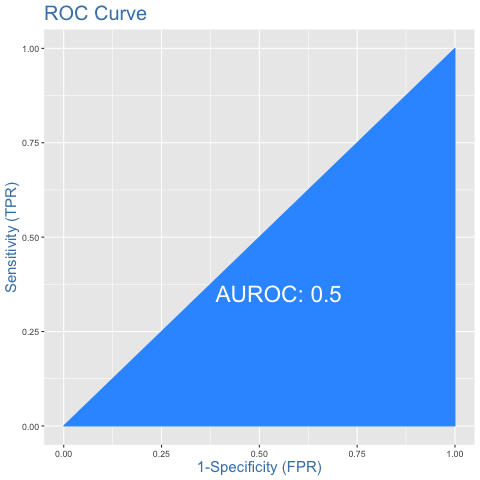

In [10]:
%%R 
library(OptimalCutpoints)
library(InformationValue)

logitMod <- glm(awardID ~ HR + AVG + Off + Def + WAR, data = Season_2017_NL, family = binomial(link = "logit"))

predicted <- predict(logitMod, Season_2018_NL, type = "response")

sort(predicted, decreasing = T)

optCutoff <- optimalCutoff(Season_2018_NL$awardID,predicted)[1]

misClassError(Season_2018_NL$awardID, predicted, threshold = optCutoff)

plotROC(Season_2018_NL$awardID, predicted)

Concordance(Season_2018_NL$awardID, predicted)

sens = sensitivity(Season_2018_NL$awardID, predicted, threshold = optCutoff)

spec = specificity(Season_2018_NL$awardID, predicted, threshold = optCutoff)


Figure 4 is a ROC curve graphing the effectiveness of the logistic regression model. The bigger the area under the ROC curve, the better the model is able to predict who are the MVP's and who are not.  Since the area under the ROC curve in figure 5 is only 0.5, this model does not fit the data. Most times, a good area under ROC curve is between .65 and 1.  If the area under the ROC curve is 1, then that means the model is a perfect fit. 

#### Figure 5

In [11]:
%%R

confusionMatrix(Season_2018_NL$awardID, predicted, threshold = optCutoff)


   0 1
0 81 6
1  1 0


Figure 6 is a confusion matrix that shows how many MVP's are guess correctly.  A MVP is labelled 1 and an individual who is not an MVP is a 0.  The 0 and 1 labelled columns show the the predicted MVP's and non-MVP's.  The 0 and 1 labelled rows are the actual MVP's and non-MVP's.  This means that there are 81 players that were correctly predicted as non-MVP's, 6 that were predicted as MVP's but are not actually MVP's, 1 player that was predicted as not an MVP, but was actually an MVP, and the model never correctly predicted a who was going to be the MVP.  

This model with this set of data does not work because the model could not correctly predict any recipient of the MVP award.  

### Attempt 2

#### Data Set

The data used for this attempt was weekly aggregated player data for the first half of the 2017 MLB season from Fangraphs, with the same MVP indicators from L's data used in the first attempt.  The decision to use weekly aggregated data is that this gives more sets of data to use to better train the model, so the model can better predict the MVP.  

The data is split into the National League and the American League to predict the MVP in each league. The training data is 65% of the first half of the 2017 season of each league.  The testing data is then the other 35% of those data sets.  

In [12]:
%%R
library(dplyr)
library(tidyr)

MVP = read.csv("~/Desktop/MLB_MVP/baseballdatabank-2019.2 2/luhmanns_data/AwardsPlayers.csv", sep = ",", stringsAsFactors = F) %>% 
  subset(awardID == "Most Valuable Player") %>% 
  subset(yearID %in% c( "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018")) %>% 
  mutate(Name = c("Alex Rodriguez", "Barry Bonds", "Vladimir Guerrero", "Barry Bonds", "Alex Rodriguez", "Albert Pujols", "Justin Morneau", "Ryan Howard", "Alex Rodriguez", "Jimmy Rollins", "Dustin Pedroia", "Albert Pujols", "Joe Mauer", "Albert Pujols", "Josh Hamilton", "Joey Votto", "Justin Verlander", "Ryan Braun", "Miguel Cabrera", "Buster Posey", "Miguel Cabrera", "Andrew McCutchen", "Mike Trout", "Clayton Kershaw", "Josh Donaldson", "Bryce Harper", "Mike Trout", "Kris Bryant", "Jose Altuve", "Giancarlo Stanton", "Christian Yelich", "Mookie Betts")) %>% 
  select("Name", "awardID")

Season_2017First = "~/Desktop/MLB_MVP/MVP_By_Week/first2017.csv" %>% 
  read.csv(header = T, sep = ",", stringsAsFactors = F)

Season_2017Second =  "~/Desktop/MLB_MVP/MVP_By_Week/second2017.csv" %>% 
  read.csv(header = T, sep = ",", stringsAsFactors = F)

Season_2017 = "~/Desktop/MLB_MVP/MVP_By_Week/third2017.csv" %>% 
  read.csv(header = T, sep = ",", stringsAsFactors = F) %>% 
  bind_rows(Season_2017First) %>% 
  bind_rows(Season_2017Second) %>% 
  left_join(MVP, by = "Name") %>% 
  mutate(awardID = case_when(awardID %in% NA ~ 0, 
                             awardID %in% "Most Valuable Player" ~ 1)) %>% 
  select("Season", "Name", "AVG", "SLG","OPS", "wRAA", "wOBA", "wRC.", "playerId", "awardID", Tm)

WAR = function(AL17_path, NL17_path, AL18_path, NL18_path){
  AL17 = read.csv(AL17_path, header = T, sep = ",", stringsAsFactors = F) %>% 
    mutate(League = "AL", Year = "2017")
  NL17 = read.csv(NL17_path, header = T, sep = ",", stringsAsFactors = F) %>% 
    mutate(League = "NL", Year = "2017")
  AL18 = read.csv(NL18_path, header = T, sep = ",", stringsAsFactors = F) %>% 
    mutate(League = "AL", Year = "2018")
  NL18 = read.csv(NL18_path, header = T, sep = ",", stringsAsFactors = F) %>% 
    mutate(League = "NL", Year = "2018")
  WAR = AL18 %>% 
    bind_rows(NL18, AL17, NL18) %>% 
    select(Name, League, WAR, Year)
}

WAR_df = WAR("~/Desktop/MLB_MVP/WAR/WAR2017AL.csv", "~/Desktop/MLB_MVP/WAR/WAR2017NL.csv", "~/Desktop/MLB_MVP/WAR/WAR2018AL.csv", "~/Desktop/MLB_MVP/WAR/WAR2018NL.csv")

First_half18 = "~/Desktop/MLB_MVP/MVP_By_Week/First_Half_Season2018.csv" %>% 
  read.csv(header = T, sep = ",", stringsAsFactors = F) %>% 
  left_join(MVP, by = "Name") %>% 
  left_join(WAR_df, by = "Name") %>% 
  mutate(awardID = case_when(awardID %in% NA ~ 0, 
                             awardID %in% "Most Valuable Player" ~ 1)) %>% 
  mutate(Season = as.character(Season)) %>% 
  mutate(League = case_when(Tm %in% c("TEX", "MIN", "BOS", "NYY",  "BAL",  "SEA",  "DET", "KCR",  "CLE",  "TOR",  "LAA" , "OAK",  "HOU", "CHW", "TBR")~ "AL",
                            Tm %in% c("CHC", "LAD", "ATL" , "NYM", "MIL",   "STL", "PHI", "SFG", "WSN" , "CIN" , "PIT" , "SDP" , "COL" , "ARI" ,  "MIA") ~ "NL"))%>% 
  distinct()%>%  
  select("Season", "Week", "Tm", "Name", "AVG", "SLG","OPS", "wRAA", "wOBA", "wRC.", "playerId", "awardID", "League", "WAR")

First_half18_AL = subset(First_half18, League == "AL")

First_half18_NL = subset(First_half18, League == "NL")

#### Figure 6

In [13]:
%%R -o First_half18_NL

First_half18_NL = First_half18_NL

In [14]:
display(First_half18_NL[0:10])

,Season,Week,Tm,Name,AVG,SLG,OPS,wRAA,wOBA,wRC.,playerId,awardID,League,WAR
3,2018,Apr 2 - Apr 8,NYM,Todd Frazier,0.235294,0.352941,0.733894,0.328785,0.333892,114.478907,785,0.0,NL,0.8
4,2018,Apr 2 - Apr 8,NYM,Todd Frazier,0.235294,0.352941,0.733894,0.328785,0.333892,114.478907,785,0.0,NL,3.1
9,2018,Apr 2 - Apr 8,LAD,Chase Utley,0.285714,0.571429,0.983193,1.197032,0.401014,157.661344,1679,0.0,NL,0.2
10,2018,Apr 2 - Apr 8,NYM,Jose Reyes,0.000000,0.000000,0.111111,-1.748039,0.076614,-57.370936,1736,0.0,NL,-0.8
13,2018,Apr 2 - Apr 8,NYM,Adrian Gonzalez,0.187500,0.375000,0.610294,-0.710125,0.263495,67.457116,1908,0.0,NL,-0.5
14,2018,Apr 2 - Apr 8,ARI,Zack Greinke,0.000000,0.000000,1.000000,0.611560,0.689530,344.565978,1943,0.0,NL,0.7
15,2018,Apr 2 - Apr 8,PIT,Ivan Nova,0.000000,0.000000,0.000000,-0.513455,0.000000,-100.000000,1994,0.0,NL,-0.4
16,2018,Apr 2 - Apr 8,LAD,Clayton Kershaw,0.000000,0.000000,0.000000,-1.540365,0.000000,-100.000000,2036,1.0,NL,0.0
17,2018,Apr 2 - Apr 8,ARI,Jorge De La Rosa,0.000000,0.000000,1.000000,0.305780,0.689530,344.565978,2047,0.0,NL,0.0
18,2018,Apr 2 - Apr 8,ARI,David Peralta,0.304348,0.608696,0.993311,2.238585,0.420242,164.693837,2136,0.0,NL,1.8


Figure 6 displays the data that was used as the training and testing data for the logistic regression model before it was split into training and testing data.

In [15]:
%%R
library(OptimalCutpoints)
table(First_half18$awardID)

MVP_ones <- First_half18_NL[which(First_half18_NL$awardID == 1), ] # all 1's

MVP_zeros <- First_half18_NL[which(First_half18_NL$awardID == 0), ] # all 0's

set.seed(200) 

MVP_ones_train <- sample(1:nrow(MVP_ones), 0.65*nrow(MVP_ones))

MVP_zeros_train <- sample(1:nrow(MVP_zeros), 0.65*nrow(MVP_zeros))

train_ones <- MVP_ones[MVP_ones_train, ]

train_zeros <- MVP_zeros[MVP_zeros_train, ]

trainingData <- rbind(train_ones, train_zeros)

test_ones <- MVP_ones[-MVP_ones_train, ]

test_zeros <- MVP_zeros[-MVP_zeros_train, ]

testData <- bind_rows(test_ones, test_zeros)


### Predictor Model

In this logistic regression model, the variables used were:
- On Base Plus Slugging - the combination of the rate of which the player reaches the base and the average number of bases reached per at bat.

<img src="files/OPS.png">

- Weighted On Base Average - the combination of all aspects of batting, weighing the metrics based on the proportion to the run value.

<img src="files/wOBA.png">

- Weighted Runs Created Plus - the value which takes into account the different weights of the different offensive measurements adjusting for different contexts, such as parks and leagues.

<img src="files/wRC.png">

The decision to use these variables were to use the most comprehensive, weighted measurements for purely batting and offensive power, because those statistics are often highlighted by the media and public. The value a player has is only how much the player can contribute to their team's success, which is often seen as mostly offensive. This decision was because most of the defensive metrics were used in the first attempt, which was unsuccessful.

##### Figure 7

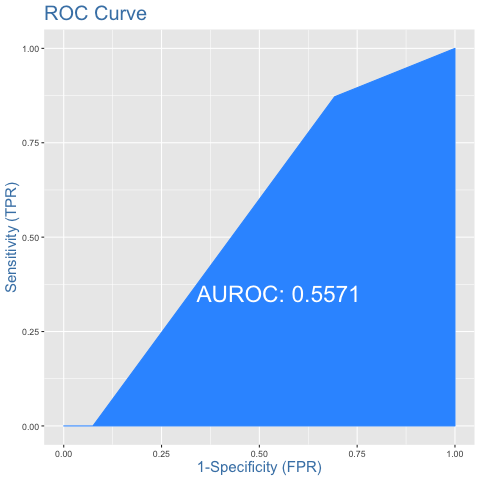

In [16]:
%%R
logitMod <- glm(awardID ~ OPS +  wOBA + wRC., data = trainingData, family = binomial(link = "logit"))

predicted <- predict(logitMod, testData, type = "response")

optCutoff <- optimalCutoff(testData$awardID,predicted)[1]

misClassError(testData$awardID, predicted, threshold = optCutoff)

plotROC(testData$awardID, predicted)


Figure 7 shows the shows the area under ROC curve, which displays the area under the ROC curve as .5571.  This ROC curve displays that the model fits the data well, but is not a great ROC curve.  

##### Figure 7

In [17]:
%%R
Concordance(testData$awardID, predicted)

sensitivity(testData$awardID, predicted, threshold = optCutoff)

specificity(testData$awardID, predicted, threshold = optCutoff)

confusionMatrix(testData$awardID, predicted, threshold = optCutoff)

#sort(predicted, decreasing = T)


     0  1
0 1579 39
1    1  0


Figure 7 shows a confusion matrix that displays how many times the MVP is guessed correctly and how many time it is not guessed correctly. This shows that 1,579 times the non-MVP was guess correctly, 39 times the model predicted the player as an MVP, when the player was not, 1 time the model guessed the player was not the MVP, when the player actually was the MVP, and the model never guessed the player correctly as the MVP.  

### Conclusion 

The main goal of this project was to use the previous season's data, tested against the first half of the current season's data, to create a logistic regression model would be able to predict the National League Most Valuable Player and the American League Most Valuable Player. Despite changing the variables, types of data, and the timeframe that the data was collected in, the model was unable to predict the Major League MVP for either league.

Some of the issues with this model is that there are not enough MVP's to be able to correctly determine the factors that go into getting the MVP award. Indicating who won the MVP award from 2003 to 2017 was necessary. If only the previous season's data was included and then only the previous year's winners were indicated, there would be hundreds of non-MVP recipients and only two MVP recipients. Even with oversampling of the training data, the model still did not work. It is more probable to determine what does not make an MVP than what does. Another issue is that there seem to be no defining variables that are able to predict an MVP. There were constant changes of variables, even making new variables and there were no significant changes that were able to help predict the MVP. There might not be one statistic that does indicate the next MVP because the MVP award is based on votes by a group of sports writers.

Sports writers use statistics to prop up their articles and their points, but that does not mean they base their vote entirely on statistics. Even if they do, it might not be the same group of statistics every time. Also, there might not be the same writers who are voting every time to be able to determine a pattern. Therefore, the second approach to this project is to determine the sentimentality the sports writers have towards the players, because the more one sports writer likes a player, the more likely they will vote for them.

## Sentimentality Towards Players Analysis

Sentiment analysis scoring is a system of scoring based on how positively or negatively a sentence is worded.  In this case, it is scoring how positively or negatively a sports writer is referring to a player in each sentence.  The more positive the sentiment is towards the player, the higher the score, and the more negative the sentiment is towards the player, the more negative the score is.  

The sentimentality portion of this project is the process of determining how positively the sports writers who are voting for the Most Valuable Player award are referring to players will then determine who will be the next MVP. The process of this approach is to pull all the articles written by designated voters from the previous year, because they do not release who votes until further in the season. The articles are then filtered to pull the names in the articles to see how often they are mentioned in the article. Then, the articles are run through a sentiment analysis scoring system that scores how positively or negatively a player is referred to in each sentence in the article. The sentiment scores are then aggregated for each player and the player with the highest score is most likely to be the next MVP.

A set of disclaimers: this part of the project is ongoing; the code is set to run every hour to pull new articles and adjust the scores. The articles were not pulled until half way through the 2019 season, so essentially this season is NULL. Multiple years need to be tested to see if this model is able to predict the MVP.

### Data Set

Every article from https://www.mlb.com/news was pulled and saved in a file, where the files were then cleaned, only grabbing the text in the articles.  The articles were then filtered based on whether the author voted for the MVP award in the previous season. The articles were put in a list of sentences, that were then filtered to only include the sentence where players were mentioned.  

Below is an example of an article from one of the selected authors after it has been cleaned.

In [18]:
#from crontab import CronTab

#cron = CronTab(user='sdelfino')
#job = cron.new(command='MLB_MVP.py')
#job.hour.every(1)

In [19]:
from selenium import webdriver
import pandas as pd
import os
import urllib
import time
from bs4 import BeautifulSoup
import numpy as np
from collections import Counter
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

In [20]:
"""automated opening google"""
driver = webdriver.Chrome(ChromeDriverManager().install())


Checking for mac64 chromedriver:76.0.3809.126 in cache
Driver found in /Users/sdelfino/.wdm/chromedriver/76.0.3809.126/mac64/chromedriver


In [21]:
driver.get('https://www.mlb.com/news')

In [22]:
import os
os.chdir('/Users/sdelfino/Desktop/MLB_updated_articles')

In [23]:
xpath = '//*[@class="template-article__content-inner"]/article/div[5]/div[3]/div/a'
"""automated scrolling through articles"""
Find_articles = driver.find_elements_by_xpath(xpath)[0]
articles_id = Find_articles.text

In [24]:
ids = driver.find_elements_by_xpath("//*[contains(@class, 'l-grid__content--card article-item article-item--article')]")
comment_ids = []
"""pulling titles of every article"""
for i in ids:
    comment_ids.append(i.get_attribute('id'))
#print(comment_ids)

In [25]:
list_of_urls = ["https://www.mlb.com/news/{}".format(i) for i in comment_ids]
#print(list_of_urls)

In [26]:
openMLB = []
"""opening of each articles"""
for x in list_of_urls: 
    openMLB.append(driver.get(x))
    time.sleep(0.1)

In [27]:
import nltk
from pathlib import Path
import re
import string
import requests
from nltk import sent_tokenize
#nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from afinn import Afinn
import numpy as np
import networkx as nx
from tabulate import tabulate
from spacy import displacy

sns.set_style("darkgrid")

In [28]:
soup = []
"""scraping of list of articles"""
for x in list_of_urls: 
    [soup.append(BeautifulSoup(urllib.request.urlopen(x)))]

In [29]:
def write_files(article_name, souped_url):
    """to open and pull the text from articles"""
    with open(article_name, 'w') as f:
        for tag in souped_url.find_all('p'):
            f.write(str(tag.text.encode('utf-8')) + '\n')

In [30]:
for i in range(0, len(comment_ids)):
    """writing articles into the text files"""
    write_files('{}.txt'.format(comment_ids[i]), soup[i])

In [31]:
file_names = []
for i in range(0, len(soup)):
    """creating list of files that were just scraped with wrtie_files for loop"""
    file_names.append('{}.txt'.format(comment_ids[i]))
#print(file_names)

In [32]:
def clean_text(text_file):    
    '''
    Reads in text file from desktop gets rid of newline and special characters
    '''
    text = open(text_file, "r").read()
    data = text.replace("b\'"," ").replace("\\xe2\\x80\\x9","").replace("\'\n","").replace("\'n"," ").replace("\'","").replace('b"'," ").replace("9s", "'s")
    data = data.replace('\\xc3\\xad', 'i').replace("\\xc3\\xba", "u").replace("\\xc3\\xa1", "a").replace('\\xe2\\x80\\xa2', ' ').replace('\\', "'").replace("\\xc3\\xa9", "h").replace("\\xc3\\x81", "a")
    data = data.replace("\\xc3\\xb3", "o").replace("\\xc3\\xa9", "e").replace("\\xe2\\x80\\xa2", "sam")
    split_dat= data.split()
    data = np.delete(split_dat,(np.r_[0:36]))
    data = ' '.join(data)
    novel=''
    novel += ' ' + data
    return novel

In [33]:
"""creating new files of each article that had been cleaned"""
for i in range(0, len(file_names)):
    file = open('{}-update.txt'.format(comment_ids[i]), "w")
    file.write(clean_text('{}.txt'.format(comment_ids[i])))
    file.close()

In [34]:
import glob
"""pulling all files from MLB_updated_articles file"""
all_files = glob.glob("*-update.txt")
#print(all_files)
#len(all_files)

In [35]:
clean_file_names = []
for i in range(0, len(all_files)):
    clean_file_names.append('{}'.format(all_files[i]))
#print(clean_file_names)

#### Figure 8

In [36]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd("**Alonso (5 hits) ties NL rookie homer record:**")
print(open("{}".format(clean_file_names[0]), "r").read())

**Alonso (5 hits) ties NL rookie homer record:**

 ATLANTA -- With 42 games left to play, Pete Alonso's season already ranks among the more productive campaigns in Mets history. Alonso has owned the franchise's rookie home run record for weeks; Thursday, in a 10-8 win over the Braves, he hit his 39th to match Cody Bellinger for the ATLANTA -- With 42 games left to play, Pete Alonso's season already ranks among the more productive campaigns in Mets history. Alonso has owned the franchise's rookie home run record for weeks; Thursday, in a 10-8 win over the Braves, he hit his 39th to match Cody Bellinger for the most by a rookie in National League history. Passing Bellinger seems a foregone conclusion, as does the Mets9 overall franchise record for homers: 41, which Todd Hundley and Carlos Beltran share. Box score Beyond that, two significant standards loom: the Major League rookie home run record, which Aaron Judge set with 52 in 2017, and the Mets9 overall RBI record, which Mike Piazza and David Wright share with 124. Alonso is just ah

This article is a basic example of an article that is pulled from the MLB News website and then cleaned.  There might be some extra symbols in the article because there are some discrepencies between how the website codes their articles and the code used in to clean the articles.  The main factors that may have left symbols are interactive features and visual display features because the code is meant to pull only text and if there are visual display features coded to alter the text, the code used cannot pick up on all of those instances.  

In [37]:
## Built out dictionary with untokenized data to use with the count vectorizer
article_untokenized={}
for i,x in enumerate(clean_file_names):
    article_untokenized['{}'.format(all_files[i])]=clean_text(x)

## built out dictionary with tokenized data
article_series={}
for i,x in enumerate(clean_file_names):
    orig_text=clean_text(x)
    sentence_list = sent_tokenize(orig_text)
    article_series['{}'.format(all_files[i])]= sentence_list

In [38]:
import spacy
nlp = spacy.load('en')

In [39]:
def name_entity_recognition(sentence):
    '''
    A function to retrieve name entities in a sentence.
    :param sentence: the sentence to retrieve names from.
    :return: a name entity list of the sentence.
    '''

    doc = nlp(sentence)
    # retrieve person and organization's name from the sentence
    name_entity = [x for x in doc.ents if x.label_ in ['PERSON']]
    # convert all names to lowercase and remove 's and ’s in names
    name_entity = [str(x).lower().replace("'s","") for x in name_entity]
    name_entity = [x.replace("’s","") for x in name_entity]
    # remove name words that are less than 3 letters to raise recognition accuracy
    #name_entity = [x for x in name_entity if len(x) >= 3]

    return name_entity

In [40]:
def flatten(l):
    """A function that flattens a complex list"""
    flat_list = []
    for i in l:
        for j in i:
            flat_list.append(j)
    return flat_list

In [41]:
def nlist(book):
    """Returns a unique list of names from a sentence tokenized book"""
    names = []
    for i in book:
        if name_entity_recognition(i) != []:
            names.append(name_entity_recognition(i))
    names = list(flatten(names))
    return names

##### Figure 9

In [42]:
twitters = pd.read_excel(io="Author_Twitters.xlsx")

twitter_handles = list(twitters["Twitter"])

twitter_handles_NAN = [x for x in twitter_handles if str(x) != 'nan']
"""twitter handles for authors that voted for MVP 2018"""
twitter_handles_clean = []
for x in range(0, len(twitter_handles_NAN)):
    twitter = twitter_handles_NAN[x].lower().strip()
    twitter_handles_clean.append(twitter)

In [43]:
print(*twitter_handles_clean, sep=', ')

@adammccalvy, @extrabaggs, @brinkpg, @billplunkettocr, @bnightengale, @brucemiles2112, @ctrent, @charlesodum, @goodforball, @clarkspencer, @dplennon, @dobrienatl, @dennistlin, @dgoold, @gdubcub, @jamalcollier, @jaysonst, @johnfayman, @jonheyman, @sdutkevinacee, @mwhicker03lang, @markzuckerman, @matt_breen, @nypost_mets, @nickpiecoro, @psaundersdp, @cmshhummel, @robbiertempfel, @haudricourt, @tracyringolsby, @bnicholsonsmith, @brendankutynj, @brianmctaggart, @chandler_rome, @smittyonmlb, @danconnolly2016, @cst_soxvan, @davecampbellap, @gfraley, @ianmbrowne, @janemlb, @beckjason, @jefffletcherocr, @jeffwilson_fwst, @flannymlb, @jonmorosi, @mlbastian, @stonelarry, @marccarig, @tbtimes_rays, @mjfennelly, @millerstrib, @richdubroffmlb, @rgriffintbj, @rustindodd, @ryandivish, @sammillerbb, @scottmerkin, @susanslusser, @zackmeisel


Above are the twitter handles for every voter of the 2018 season.  The reason to use the writer's twitter handles are because MLB.com includes every writer's Twitter handle at the end of every article.  

In [44]:
list_of_articles = []
for x in range(0, len(article_series)):
    '''
    instead of recently scraped files' titles, pass through every single title with update in it on laptop 
    '''
    list_of_articles.append(open('{}'.format(all_files[x]), "r").read()) 
#print(list_of_articles)
#len(list_of_articles)

In [45]:
list_of_articles_lower = []
for x in range(0, len(list_of_articles)):
    article = list_of_articles[x].lower()
    list_of_articles_lower.append(article)
#print(list_of_articles_lower)

In [46]:
correct_authors = []
correct_authors_titles = []
list_of_new_articles = []
article_names = [s.strip('-update.txt') for s in all_files]
for x in range(0, len(list_of_articles_lower)):
    for i in range(0, len(twitter_handles_clean)):
        if twitter_handles_clean[i] in list_of_articles_lower[x]:
            """list of articles names that have been written by authors who voted"""
            correct_authors.append(article_series['{}'.format(all_files[x])])
            """list of new names for such articles to be stored later"""
            correct_authors_titles.append('{}-AUTHORS.txt'.format(article_names[x]))
            """list of text from each article"""
            list_of_new_articles.append(list_of_articles[x])
#print(correct_authors_titles)
#print(correct_authors)
#print(list_of_new_articles)

In [47]:
for x in range(0, len(correct_authors_titles)):
    open("{}".format(correct_authors_titles[x]), "w").write(list_of_articles[x])

In [48]:
func_list = []
for x in range(0, len(correct_authors)):
    """pulling all names from each article"""
    func_list.append(nlist(correct_authors[x]))
#print(func_list)

In [49]:
def FN(lofn):
    full_names = []
    for x in range(0, len(lofn)):
        if len(lofn[x].split()) == 2:
            full_names.append(lofn[x].title())
    return list(set(full_names))


In [50]:
full_names_l = []
for x in range(0, len(func_list)):
    """pulling only full names"""
    full_names_l.append(FN(func_list[x]))
#print(full_names_l)

In [51]:
def pull_last_names(lofn):
    loln = []
    """pulling all last names from articles"""
    for x in range(0, len(lofn)):
        loln.append(lofn[x].split()[1])
    return loln

In [52]:
last_names_l = []
for x in range(0, len(full_names_l)):
    last_names_l.append(pull_last_names(full_names_l[x]))
#print(last_names_l)

In [53]:
def name_dict(full, last):
    """func to create dict of full names corresponding to last names"""
    return dict(zip(full, last))

In [54]:
FLN_dict = []
for x in range(0, len(last_names_l)):
    FLN_dict.append(name_dict(full_names_l[x], last_names_l[x]))
#print(FLN_dict)

In [55]:
def replace_last(article, dictionary):
    """func to replace last names or first names to full names"""
    for last, full in dictionary.items():
        article = article.replace(full, last)
        article = article.replace(last, full)
    return article

In [56]:
articles = []
for x in range(0, len(correct_authors_titles)):
    articles.append(open(correct_authors_titles[x], "r").read())

In [57]:
super_clean = []
for x in range(0, len(FLN_dict)):
    """replacing names so only full names are listed"""
    super_clean.append(replace_last(list_of_articles[x], FLN_dict[x]))
#print(super_clean)

In [58]:
for x in range(0, len(correct_authors_titles)):
    file = open(correct_authors_titles[x], "w")
    file.write(super_clean[x])
    file.close()

In [59]:
super_clean_file_names = []
"""list of all names of all articles written by an author that voted for MLB MVP in 2018"""
for i in range(0, len(correct_authors_titles)):
    super_clean_file_names.append(correct_authors_titles[i])
#print(super_clean_file_names)

#### Figure 10

In [60]:
printmd("**Moncada progressing, set for rehab assignment:**")
print(open("yoan-moncada-to-begin-rehab-assignmen-AUTHORS.txt", "r").read())

**Moncada progressing, set for rehab assignment:**

 WASHINGTON -- When the fifth inning began in Wednesday's series finale, the Nationals had collected just one hit and one run, kept off-balance by Reds starter Trevor Bauer. What followed was Washington's highest scoring inning of the season and the second-highest runs total in a frame in team history.'n The WASHINGTON -- When the fifth inning began in Wednesday's series finale, the Nationals had collected just one hit and one run, kept off-balance by Reds starter Trevor Bauer. What followed was Washington's highest scoring inning of the season and the second-highest runs total in a frame in team history. The Nationals scored 10 runs in the game-changing fifth at Nationals Park, an offensive outburst that brought 13 hitters to the plate, saw every member of the lineup score and featured three homers to lift the Nats to a 17-7 victory, completing a three-game sweep of the Reds. Box score According to the Elias Sports Bureau, this was the first time in Nationals history every player in t

Figure 10 displays an article written by Jamal Collier who was the one of the writers who voted for the MLB MVP in 2018.  This is an example of an article that will be put through the sentiment analysis scorer.  

In [61]:
## Built out dictionary with untokenized data to use with the count vectorizer
## All I really saw in terms of issues was ... being frequently used which I substituted with ;
article_untokenized_authors={}
for i,x in enumerate(super_clean_file_names):
    article_untokenized_authors[correct_authors_titles[i]]=clean_text(x)

## built out dictionary with tokenized data    
article_series_authors={}
for i,x in enumerate(super_clean_file_names):
    orig_text=clean_text(x)
    sentence_list = sent_tokenize(orig_text)
    article_series_authors[correct_authors_titles[i]]= sentence_list

In [62]:
func_list_up = []
for x in range(0, len(article_series_authors)):
    """name of people mentioned in each article"""
    func_list_up.append(nlist(article_series_authors['{}'.format(super_clean_file_names[x])]))
#print(func_list_up)

In [63]:
def freq(lon):
    """counting freq name in each article"""
    countnames = {}
    for name in lon:
        if name in countnames:
            countnames[name] += 1
        else:
            countnames[name] = 1
    return countnames

In [64]:
flat = flatten(func_list_up)
def pull_last_names_freq(lofn):
    loln = []
    """pulling all last names from articles"""
    for x in range(0, len(lofn)):
        if len(lofn[x].split()) == 2:
            loln.append(lofn[x].split()[1])
        elif len(lofn[x].split()) == 3:
            loln.append(lofn[x].split()[2])
        elif len(lofn[x].split()) == 1:
            loln.append(lofn[x].split()[0])
    return loln


In [65]:
last_name_freq = pull_last_names_freq(flat)
freq_all = freq(flat)

In [66]:
freq_dict = []
for x in range(0, len(func_list_up)):
    freq_dict.append(freq(func_list_up[x]))
#print(freq_dict)

In [67]:
import json
"""writing list of name frequency in each article to individual files"""
for x in range(0, len(freq_dict)):
    with open('{}_DICT.txt'.format(article_names[x]), 'w') as file:
        file.write(json.dumps(freq_dict[x]))

#### Figure 11

In [68]:
super_clean8 = open('yoan-moncada-to-begin-rehab-assignmen-AUTHORS.txt', "r").read()

doc = nlp(super_clean8)
printmd("**Moncada progressing, set for rehab assignment:**")
displacy.render(doc, style="ent")

**Moncada progressing, set for rehab assignment:**

Figure 11 is an article that was tokenized and then passed through named recognition software that categories different parts of each sentence to visualize how each name is determined in the sentence.  This is not perfect and is based on assumptions of defined conventions of the English written language.

In [69]:
def create_table(freq_dict):
    """creating table of name freq"""
    DF = pd.DataFrame(list(freq_all_cor.items()), columns=['name', 'freq'])
    return DF

In [70]:
freq_all_cor = {'cody bellinger': 8,
 'pete alonsos': 2,
 'todd hundley': 1,
 'carlos beltran': 1,
 'box': 3,
 'aaron judge': 1,
 'mike piazza': 1,
 'david wright': 1,
 'mickey callaway': 2,
 'amed rosario': 5,
 'juan lagares': 1,
 'julio teheran': 1,
 'drew gagnon': 1,
 'edwin diaz': 2,
 'anthony dicomo': 1,
 'facebook': 1,
 'trevor bauer': 2,
 'kurt suzuki': 2,
 'adam eaton': 1,
 'stephen strasburg': 1,
 'anthony rendon': 1,
 'dave martinez': 1,
 'jamal collier': 1,
 'baltimore': 1,
 'brandon hyde': 3,
 'roberto osuna': 1,
 'ruiz': 2,
 'justin verlander': 1,
 'luke scott': 1,
 'luca james': 1,
 'asher wojciechowski': 1,
 'trey mancini': 2,
 'jonathan villar': 1,
 'jace peterson': 1,
 'pedro severino': 1,
 'mychal givens': 1,
 'michael brantley': 2,
 'anthony santanders': 1,
 'baltimores': 1,
 'chris davis': 2,
 'joe trezza': 1,
 'shohei ohtanis': 1,
 'vladimir guerrero jr.': 2,
 'tommy pham': 4,
 'aaron hicks': 1,
 'yasiel puig': 2,
 'alex gordon': 2,
 'miguel cabrera': 1,
 'eddie rosario': 3,
 'jon jay': 1,
 'albert pujols': 1,
 'carlos correa': 2,
 'jose altuve': 1,
 'daniel vogelbach': 1,
 'joey gallo': 1,
 'inciarte': 2,
 'juan soto': 2,
 'scott kingery': 1,
 'eric thames': 1,
 'jose martinez': 2,
 'javier baez': 2,
 'baez': 1,
 'josh osuna': 1,
 'joey votto': 1,
 'david peralta': 1,
 'fernando tatis jr.': 3,
 'charlie blackmon': 1,
 'jose canseco': 1,
 'mark mcgwire': 1,
 'matt chapman': 3,
 'matt olson': 1,
 'aaron sanchez': 1,
 'coliseum': 2,
 'astros': 1,
 'blake treinen': 1,
 'chris devenski': 1,
 'bob melvin': 1,
 'christian yelich': 2,
 'corban josephs': 1,
 'joseph': 2,
 'melvin': 1,
 'martin gallegos': 1,
 'rays': 2,
 'aristides aquino': 4,
 'jake arrieta': 1,
 'aaron nola': 1,
 'bryce harper': 3,
 'brewers': 1,
 'rangers': 1,
 'richard justice': 1,
 'josh hader': 3,
 'marwin gonzalezs': 4,
 'craig kimbrels': 1,
 'adam mccalvy': 1,
 'derek johnson': 1,
 'mike petriello': 1,
 'padres9': 1,
 'dave stewart': 1,
 'carson kelly': 1,
 'rafael devers': 1,
 'mookie betts': 1,
 'brodie van wagenen': 1,
 'marcus stroman': 1,
 'jose ramirez': 1,
 'max scherzer': 1,
 'wild card game': 1,
 'charlie morton': 1,
 'brandon lowe': 2,
 'austin meadows': 1,
 'avisail garcia': 1,
 'travis darnaud': 1,
 'brandon moss': 1,
 'tony cruz': 1,
 'joe maddon': 1,
 'ryan howard': 1,
 'roy halladay': 1,
 'jameson taillon': 1,
 'tommy john': 2,
 'david altchek': 1,
 'david adler': 2,
 'ryan mountcastle': 1,
 'mountcastle': 1,
 'adley rutschman': 4,
 'michael baumann': 2,
 'gunnar henderson': 1,
 'jorge soler': 1,
 'mike moustakas': 1,
 'eric hosmer': 1,
 'scooter gennett': 1,
 'rhys hoskins': 2,
 'yu darvish': 1,
 'brad miller': 1,
 'ian happs': 1,
 'pedro strop': 1,
 'roman quinn': 1,
 'gabe kapler': 1,
 'drew smyly': 1,
 'todd zolecki': 1,
 'ryan yarbroughs': 1,
 'matt andriese': 1,
 'kevin cash': 1,
 'emilio pagan': 1,
 'omar narvaez': 2,
 'domingo santana': 2,
 'kyle snyder': 1,
 'scott servais': 1,
 'yandy diaz': 1,
 'blake snell': 1,
 'tyler glasnow': 1,
 'yonny chirinos': 1,
 'mallex smith': 2,
 'j.p. crawford': 1,
 'dee gordon': 1,
 'kyle seager': 1,
 'daniel kramer': 1,
 'dave roberts': 2,
 'marlins': 1,
 'will smith': 1,
 'rick honeycutt': 1,
 'corey seager': 1,
 'justin turner': 1,
 'dustin may': 1,
 'smiths': 1,
 'twitter @cdenicola13': 1,
 'brad hand': 4,
 'jason kipnis': 2,
 'carlos santana': 2,
 'terry francona': 2,
 'starter aaron civale': 2,
 'blown': 2,
 'marwin gonzalez': 2,
 'kip': 2,
 'tyler naquin': 6,
 'francisco lindor': 10,
 'kevin plawecki': 2,
 'greg allen': 2}

In [71]:
DF = create_table(freq_all_cor)
DF_up = DF[DF['freq'] >= 3]

In [72]:
def name_freq_plot(df,title):
    """plot for name freq"""
    sns.barplot(data=df, 
                y=df.name, 
                x=df.freq,
                color='blue')
    plt.title(title)
    plt.show()

#### Figure 12

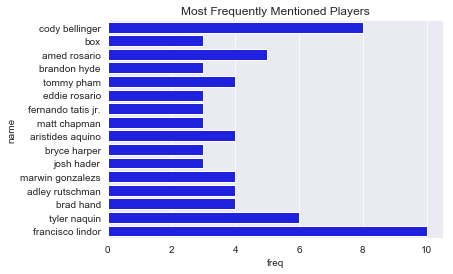

In [73]:
name_freq_plot(DF_up, "Most Frequently Mentioned Players")

Figure 12 displays the frequency of the names mentioned in the articles written by the predefined sports writers.

In [74]:
def calculate_matrix(sentence_list):
    '''
    Function to calculate the co-occurrence matrix and sentiment matrix among all the top characters
    :param sentence_list: the list of sentences in the novel.
    :return: list of sentiment scores per sentence.
    '''

    # calculate a sentiment score for each sentence in the novel
    afinn = Afinn()
    sentiment_score = [afinn.score(x) for x in sentence_list]
    

    return sentiment_score

In [75]:
sentence_names = []
"""function to pull sentences where there are names mentioned"""
def selecting_sentences(list_of_sentences, list_of_names):
    for x in range(0, len(list_of_sentences)):
        for i in range(0, len(list_of_names)):
            if list_of_names[i] in list_of_sentences[x]:
                sentence_names.append(list_of_sentences[x])

In [76]:
for x in range(0, len(article_series_authors)):
    for i in range(0, len(full_names_l)):
        selecting_sentences(article_series_authors['{}'.format(super_clean_file_names[x])], full_names_l[i])
#print(sentence_names)

In [77]:
sentiment_matrix1 = calculate_matrix(sentence_names)
#print(sentiment_matrix1)

In [78]:
import re
"""fixing string of all players scraped through r"""
player_list = open("player_list.txt", "r").read() 

player_list = re.sub('\n', '', player_list)

for x in range(1, 103):
    player_list = re.sub('{}'.format(x), '', player_list)
#print(player_list)

player_list = re.sub('""', '', player_list)
player_list = re.sub('0', '', player_list)
player_list = re.sub('"x"', '', player_list)
"""turning split into list"""
player_list = player_list.replace('" "', '", "').split('", "')
"""create list of all names that must be edited"""
longer_names = []
for x in range(0, len(player_list)):
    if "." in player_list[x] or "'" in player_list[x] or "De " in player_list[x] or "-" in player_list[x]:
        longer_names.append(player_list[x])
#print(longer_names)

In [79]:
shorter_names = []
"""create list of all names that did not need to be edited manually"""
for x in range(0, len(player_list)):
    if "." not in player_list[x] and  "'" not in player_list[x] and "De " not in player_list[x]and "-" not in player_list[x]:
        shorter_names.append(player_list[x])
#print(shorter_names)
shorter_names[len(shorter_names)-1] = shorter_names[len(shorter_names)-1].replace('"', '')
shorter_names[0] = shorter_names[0].replace(' "', '')

In [80]:
"""long_names are all of the names that needed to be edited manually"""
long_names = ['Wei-Yin Chen', 'Ji-Man Choi', 'Shin-Soo Choo', 'Li-Jen Chu', 'Tyler Depreta-Johnson', 'Ray-Patrick Didder', 'Chih-Wei Hu', 'Wei-Chieh Huang', 'Jin-De Jhang', 'Isiah Kiner-Falefa', 'Tzu-Wei Lin', 'Seth Mejias-Brean', 'Sean Reid-Foley', 'Hyun-Jin Ryu', 'Dom Thompson-Williams', 'Abraham Toro-Hernandez', 'Jen-Ho Tseng', 'Wei-Chung Wang',"Ka'Ai Tom", 'Alex De Goti', 'Adrian De Horta', 'Chase De Jong', 'Isrrael De La Cruz', 'Michael De La Cruz', 'Oscar De La Cruz', 'Chad De La Guerra', 'Rubby De La Rosa', 'Michael De Leon', 'José De León', 'Enyel De Los Santos', 'Luis De Los Santos', 'Rafael De Paula', 'Ronald Acuña Jr.', "Ke'Bryan Hayes", "Peter O'Brien", "Darren O'Day", "Brian O'Grady", "Ryan O'Hearn", "Brian O'Keefe", "Tyler O'Neill", "Ryan O'Rourke", "Chase d'Arnaud", "Travis d'Arnaud", 'Albert Almora Jr.', 'R.J. Álvarez', 'D.J. Baxendale', 'Jackie Bradley Jr.', 'J.B. Bukauskas', 'D.J. Burt', 'J.T. Chargois', 'C.J Chatham', 'A.J. Cole', 'P.J. Conlon', 'Nestor Cortes Jr.', 'J.P. Crawford', 'C.J. Cron', 'J.D. Davis', 'Carl Edwards Jr.', 'J.C. Escarra', 'J.P. Feyereisen', 'J.J. Franco', 'Vladimir Guerrero Jr.', 'Lourdes Gurriel Jr.', 'J.A. Happ', 'P.J. Higgins', 'C.J. Hinojosa', 'Brent Honeywell Jr.', 'J.J. Hoover', 'Torii Hunter Jr.', 'Mark Leiter Jr.', 'J.D. Martin', 'J.D. Martinez', 'L.J. Mazzilli', 'Lance McCullers Jr.', 'T.J. McFarland', 'A.J. Minter', 'T.J. Nichting', 'R.C. Orlan', 'C.D. Pelham', 'D.J. Peterson', 'A.J. Pollock', 'J.T. Realmuto', 'T.J. Rivera', 'Fernando Rodríguez Jr.', 'Josh A. Smith ', 'Josh D. Smith ', 'Dwight Smith Jr.', 'Steven Souza Jr.', 'St. John Locke', 'Troy Stokes Jr.', 'Fernando Tatis Jr.', 'Michael A. Taylor', 'Duane Underwood Jr.', 'J.B. Wendelken', 'D.J. Wilson', 'Eric Young Jr.']
correct_players = shorter_names + long_names

In [81]:
import unicodedata
"""function to replace all special characters with its english alphabetic counterpart"""
def strip_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

In [82]:
final_player_list = []
"""filtering out all special characters"""
for x in correct_players:
    normalized_players = strip_accents(x)
    final_player_list.append(normalized_players)
#print(final_player_list)

In [83]:
full_names_authors = []
"""pulling list of all names in the article"""
for x in range(0, len(func_list)):
    full_names_authors.append(FN(func_list[x]))
    all_names = flatten(full_names_authors)
#print(all_names)

In [84]:
players_in_article = []
"""creating list of players mentioned in the articles"""
for x in range(0, len(all_names)):
    for y in range(0, len(final_player_list)):
        if all_names[x] in final_player_list[y]:
            players_in_article.append(all_names[x])
#print(players_in_article)

In [85]:
name_per_sent = []
"""creating list of list of names from the individual article and putting the list of names into a list"""
for sentnum in range(0, len(sentence_names)):
    name_per_sent_ind = []
    name_per_sent.append(name_per_sent_ind)
    for namenum in range(0, len(players_in_article)):
        if players_in_article[namenum] in sentence_names[sentnum]:
            name_per_sent_ind.append(players_in_article[namenum])
#print(name_per_sent)

In [86]:
sentiment_dict = {}
"""summing sentiment towards players and creating a dictionary for it"""
for sentencenum in range(0, len(sentence_names)):
    for name in name_per_sent[sentencenum]:
        if name in sentiment_dict:
            sentiment_dict[name] += sentiment_matrix1[sentencenum]
        else:
            sentiment_dict[name] = sentiment_matrix1[sentencenum]
#print(sentiment_dict)

#### Figure 13

In [87]:
from collections import OrderedDict
from operator import itemgetter
d = OrderedDict(sorted(sentiment_dict.items(), key=itemgetter(1), reverse = True))
pd.DataFrame(list(d.items()), columns=['Player_name', 'Sentiment_value'])

,Player_name,Sentiment_value
0,Chris Devenski,48.0
1,Carlos Correa,24.0
2,Rafael Devers,16.0
3,Mallex Smith,16.0
4,J.P. Crawford,16.0
5,Jose Altuve,12.0
6,Omar Narvaez,6.0
7,Corban Joseph,5.0
8,Pete Alonso,4.0
9,Matt Olson,3.0


Figure 13 displays the aggregated scores of every player mentioned in the articles written by the sportswriter who voted for the 2018 MVP award.  

#### Figure 14

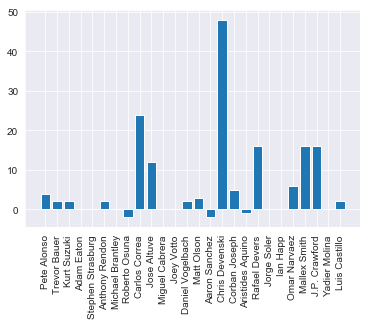

In [88]:
import matplotlib.pyplot as plt
"""plot sum of sentiment towards player"""
plt.bar(range(len(sentiment_dict)), list(sentiment_dict.values()), align='center')
plt.xticks(range(len(sentiment_dict)), list(sentiment_dict.keys()), rotation=90)
plt.show()

Figure 14 displays the aggregated scores of the players in a bar graph to show the difference between the different players.  

### Conclusion 

Ultimately, the goal of this model is to be able to predict the next Major League Baseball National League and American League Most Valuable Player based on name recognition software and sentiment analysis scoring. It is meant to take into account the human aspect of the voting process for the award. If this project works, it will then prove that the MVP race is not based on purely statistics, but on a popularity contest and public opinion.
The sentiment analysis of each player in every article might be a way to be able to predict the next Major League Baseball Most Valuable Player, but it cannot be determined for at least two more years. Although this model is not finalized, there are some known challenges with this approach. All articles were scraped from MLB.com, however, not all the writers that vote for the MVP award also write for MLB.com. MLB.com was one of the few websites that does not have their articles embedded in javascript, so it is significantly easier to pull the articles from the MLB.com website. For future updates to this project, articles from other websites can be pulled to have a well-rounded selection of data to use.

Another problem is that there is no guarantee that the same group of writers will vote every year. As a result, we can be missing a voter with the one lag year of the release of the list of voters. That problem cannot be solved unless the voter lists are released at the beginning of the year so that only articles from voting authors are pulled.

This model does not include the separation of American League players and National League players, so there is no way to guess the MVP's separately. Eventually, the player names will need to be separated based on the league they play in. This list will need to be constantly updated throughout the season until after the trade deadline. Every new season, the list must be updated again.

There is also a possibility of error with the name recognition software itself. These errors can include:
- not pulling every sentence
- not removing junk characters properly
- inaccurately scoring the player sentiment scores
These errors always have a possibility of occurring because machine learning software can never fully understand everything in the English language and the actions of humans.


## Overarching Conclusion 

In this project I began analyzing the pure statistics for each player through a logistic regression model. After trying many combinations of variables, timeframes of the collected data, and sets of data, the model could not properly predict the National League and American League MVP. The second approach I had towards the project was analyzing opinion. The MVP award is based on a group of sports writers voting, who are paid to report not just on the players' statistics, but also on their value as players and their team as a whole. That value could mean many different things to many different people. The attempt to give that value a numerical value was through sentiment analysis scoring. The scoring of how positively or negatively the sports writer refers to the player may display how the sports writer values that player, then allows this project to be able to predict who these sports writers determine is the most valuable player.

Through this project, I was able to learn that even in the most statistics dominated sport, not everything can be determined through statistics. The human aspect of the sport will never go away, especially in the race for the Most Valuable Player award. I also learned different ways to analyze statistics and learned there are more ways to approach a project, especially in data science than just analyzing pure data. This project will be a continual work in progress because the world of baseball will always be changing as will personal and public opinion.

## References

1. Chan, Austin, et al. “Final Project - Game of Thrones.” Github, 17 July 2019, github.com/chesterpoon8/GOT_Project/blob/master/GOT.ipynb.
2. “Download Lahman’s Baseball Database.” SeanLahman.com, Data, 2019, www.seanlahman.com/baseball-archive/statistics/.
3. Prabhakaran, Selva. “Logistic Regression .” r-Statistics.co , Selva Prabhakaran, 2016-17, r-statistics.co/Logistic-Regression-With-R.html.
4. Slowinski, Steve. “What Is WAR?” Fangraphs, Fangraphs, 15 Feb. 2010, library.fangraphs.com/misc/WAR/.
5. “Splits Leaderboard.” Fangraphs, www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=2017&month=0&season1=2017&ind=0&team=&rost=&age=&filter=&players=&startdate=&enddate=.
6. “Splits Leaderboard.” Fangraphs, https://www.fangraphs.com/leaders/splits-leaderboards?splitArr=&splitArrPitch=&position=B&autoPt=false&splitTeams=false&statType=player&statgroup=2&startDate=2017-03-01&endDate=2017-10-02&players=&filter=&sort=19,1.
7. “Splits Leaderboard.” Fangraphs, https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=2018&month=1000&season1=2018&ind=0&team=&rost=&age=&filter=&players=&startdate=2018-04-02&enddate=2018-07-17
8. Weinberg, Neil. “Complete List (Offense).” Fangraphs, Fangraphs, 30 Oct. 2014, library.fangraphs.com/offense/offensive-statistics-list/.
9. Weinberg, Neil. “Overview.” Fangraphs, Fangraphs, 12 Mar. 2015, library.fangraphs.com/defense/overview/.